In [1]:
from keras.layers import Dense,Activation,Dropout
from keras.layers import LSTM
from keras.models import Sequential
import time
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
# 读取数据
def normalise_windows(window_data):
    normalised_data = []
    # 归一化操作
    for window in window_data:
        normalise_window = [((float(p)/float(window[0]))-1) for p in window]
        normalised_data.append(normalise_window)
    return normalised_data
        
def load_data(filename, seq_len, normalise_window):
    with open(filename,'r') as f:
        data = f.read().split('\n')
    
    # 预测目标y为最后一位
    sequence_length = seq_len + 1
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index:index + sequence_length])
    
    if normalise_window:
        result = normalise_windows(result)
    result = np.array(result)
    
    # 保留验证集
    row = round(0.9*result.shape[0])
    train = result[:int(row),:]
    np.random.shuffle(train)
    x_train = train[:,:-1]
    y_train = train[:,-1]
    x_test = result[int(row):,:-1]
    y_test = result[int(row):,-1]
    
    x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))
    x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))
    
    return [x_train,y_train,x_test, y_test]

In [3]:
X_train, y_train, X_test, y_test = load_data('sp500.csv', 50, True)
print(X_train[0,:])
print(y_train[0])

[[ 0.        ]
 [-0.00184478]
 [-0.00321857]
 [ 0.00049457]
 [ 0.0095066 ]
 [ 0.00777959]
 [ 0.01522158]
 [ 0.01661895]
 [ 0.00633518]
 [ 0.00503202]
 [ 0.00745771]
 [ 0.01333751]
 [ 0.01360449]
 [ 0.01788282]
 [ 0.02016726]
 [ 0.0019547 ]
 [ 0.00963223]
 [ 0.02648663]
 [ 0.023692  ]
 [ 0.02610197]
 [ 0.02906152]
 [ 0.03548304]
 [ 0.03981628]
 [ 0.0369196 ]
 [ 0.03769676]
 [ 0.04341174]
 [ 0.0459002 ]
 [ 0.04251681]
 [ 0.04904029]
 [ 0.05226681]
 [ 0.05429213]
 [ 0.03264903]
 [ 0.02633752]
 [ 0.02531695]
 [ 0.03613458]
 [ 0.04189661]
 [ 0.02549749]
 [ 0.02715388]
 [ 0.04484044]
 [ 0.03713157]
 [ 0.02848061]
 [ 0.03765747]
 [ 0.03624449]
 [ 0.01668957]
 [ 0.02388825]
 [ 0.01769442]
 [ 0.00629589]
 [-0.0133218 ]
 [-0.00010206]
 [ 0.00420771]]
0.019256607498652656


In [15]:
#  建立模型
model = Sequential()

model.add(LSTM(input_shape=(None, 1),units=50,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(100, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.add(Activation('linear'))

start = time.time()
model.compile(loss='mse',optimizer='adam')
print('compilation time : ', time.time() -start)

compilation time :  0.021955251693725586


In [21]:
model.fit(X_train, y_train, batch_size=512, epochs=5, validation_split=0.05)

Train on 3523 samples, validate on 186 samples
Epoch 1/5
3523/3523 [==============================] - 1s 280us/step - loss: 4.1796e-04 - val_loss: 3.5215e-04
Epoch 2/5
3523/3523 [==============================] - 1s 266us/step - loss: 4.1774e-04 - val_loss: 3.4638e-04
Epoch 3/5
3523/3523 [==============================] - 1s 267us/step - loss: 3.9937e-04 - val_loss: 3.3258e-04
Epoch 4/5
3523/3523 [==============================] - 1s 266us/step - loss: 3.9662e-04 - val_loss: 3.3136e-04
Epoch 5/5
3523/3523 [==============================] - 1s 270us/step - loss: 3.7223e-04 - val_loss: 3.2043e-04


In [22]:
def predict_sequences_multiple(modle, data, window_size, prediction_len):
    prediction_seqs = []
    for i in range(int(len(data)/prediction_len)):
        # 取出某个窗口的数据
        curr_frame = data[i*prediction_len]
        predicted = []
        for j in range(prediction_len):
            # 存储预测值
            predicted.append(model.predict(curr_frame[np.newaxis,:,:])[0,0])
            # 把预测值作为输入序列最后一位，重新预测
            curr_frame = curr_frame[1:]
            curr_frame = np.insert(curr_frame,[window_size-1], predicted[-1], axis=0)
        prediction_seqs.append(predicted)
    return prediction_seqs

In [23]:
prediction_len = 50

In [24]:
predictions = predict_sequences_multiple(model,X_test,50,prediction_len)

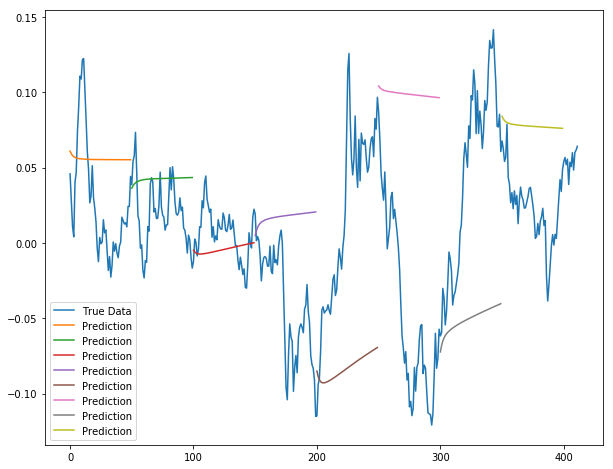

In [25]:
fig = plt.figure(facecolor='white',figsize=(10,8))
ax = fig.add_subplot(111)
ax.plot(y_test, label='True Data')

for i, data in enumerate(predictions):
    padding = [None for p in range(i*prediction_len)]
    plt.plot(padding+data, label='Prediction')
    
plt.legend(loc='best')
plt.show()